# Head

In [1]:
import sys
sys.path.append("clustering")

from utils import get_data_dir, Scopus2abbr, Scopus2color

In [2]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_parquet(os.path.join(get_data_dir(), '2010s/clustering_results/cluster_df.parquet'), 
                     columns=['Scopus_label', 'x_val', 'y_val', 'kmeans_label'])
df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,x_val,y_val,kmeans_label
202381698,Multidisciplinary,-67.928200,15.572327,17
137773608,Multidisciplinary,-68.405334,-55.633186,17
125754415,Multidisciplinary,-68.448853,-55.613579,17
3880285,Multidisciplinary,-68.407288,-55.634430,8
111155417,Chemistry,-54.506985,-61.217068,11
...,...,...,...,...
2764485818,Medicine,-28.969574,34.819569,18
83454320,Arts and Humanities,78.609909,31.736822,13
16507453,Arts and Humanities,89.206772,17.625090,13
121509672,Agricultural and Biological Sciences,-36.757057,-0.591017,21


In [4]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def match_labels_hungarian(df):
    # Create a contingency table
    contingency = pd.crosstab(df['kmeans_label'], df['Scopus_label'])
    
    # Convert to cost matrix (negative because we want to maximize the overlap)
    cost_matrix = -contingency.values
    
    # Apply Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create mapping from kmeans labels to Scopus labels
    kmeans2Scopus = {
        contingency.index[i]: contingency.columns[j]
        for i, j in zip(row_ind, col_ind)
    }
    
    # Create a new column with matched Scopus labels
    df_matched = df.copy()
    df_matched['matched_Scopus'] = df['kmeans_label'].map(kmeans2Scopus)
    
    # Calculate accuracy
    accuracy = (df_matched['matched_Scopus'] == df_matched['Scopus_label']).mean()
    
    # Print results
    print(f"Matching accuracy: {accuracy:.4f}")
    
    # Return the mapping and matched dataframe
    return kmeans2Scopus, df_matched

In [5]:
kmeans2Scopus, df_matched = match_labels_hungarian(df)

Matching accuracy: 0.4326


In [7]:
from clusim.clustering import Clustering
import clusim.sim as sim

# Key: row index, val: value of 'area' column
dict_original = {index: [row['Scopus_label']] for index, row in df.iterrows()}
# Key: row index, val: value of 'cluster_label' column
dict_clustering = {index: [row['kmeans_label']] for index, row in df.iterrows()}

c_original = Clustering(elm2clu_dict = dict_original)
c_clustering = Clustering(elm2clu_dict = dict_clustering)

elementScores, relabeled_elements = sim.element_sim_elscore(c_original, c_clustering, alpha = 0.9)
df['sim_score'] = elementScores
df

,Scopus_label,x_val,y_val,kmeans_label,sim_score
202381698,Multidisciplinary,-67.928200,15.572327,17,0.291221
137773608,Multidisciplinary,-68.405334,-55.633186,17,0.258740
125754415,Multidisciplinary,-68.448853,-55.613579,17,0.176090
3880285,Multidisciplinary,-68.407288,-55.634430,8,0.056494
111155417,Chemistry,-54.506985,-61.217068,11,0.709161
...,...,...,...,...,...
2764485818,Medicine,-28.969574,34.819569,18,0.081355
83454320,Arts and Humanities,78.609909,31.736822,13,0.003559
16507453,Arts and Humanities,89.206772,17.625090,13,0.399829
121509672,Agricultural and Biological Sciences,-36.757057,-0.591017,21,0.221676


<Figure size 640x480 with 0 Axes>

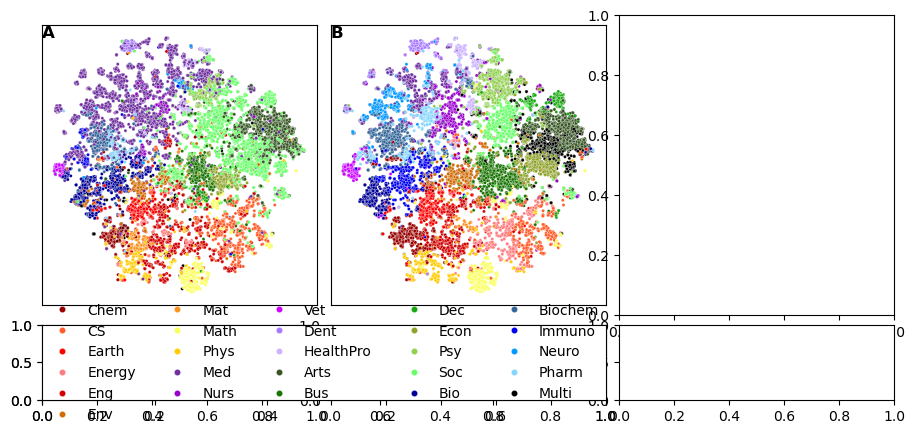

In [6]:
fig = plt.figure(layout='constrained')
fig, axes = plt.subplots(2, 3, figsize=(11, 5), gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 0.25]})
plt.subplots_adjust(wspace=0.05, hspace=0.05)
axes = axes.flatten()

# First plot (Scopus labels)
scatter = sns.scatterplot(data=df, x='x_val', y='y_val', 
                          hue='Scopus_label', palette=Scopus2color, s=5,
                          ax=axes[0])
axes[0].set_aspect('equal')
axes[0].legend().set_visible(False)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].text(0, 1, 'A', transform = axes[0].transAxes, 
             fontsize=12, fontweight='bold', va='top', ha='left')

# Second plot (matched Scopus labels)
scatter = sns.scatterplot(data=df_matched, x='x_val', y='y_val', 
                          hue='matched_Scopus', palette=Scopus2color, s=5,
                          ax=axes[1])
axes[1].set_aspect('equal')
axes[1].legend().set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].text(0, 1, 'B', transform = axes[1].transAxes, 
             fontsize=12, fontweight='bold', va='top', ha='left')

# Third plot (similarity between KMeans label and Scopus label)

# Hide unused axes
# for i in range(2, 5):
#     axes[i].set_visible(False)

axes[3] = plt.subplot2grid((2, 3), (1, 0), colspan=2)

# Get all the Scopus labels in the desired order
ordered_labels = list(Scopus2color.keys())
# Create a dictionary that maps labels to handles
handles, labels = scatter.get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
# Create ordered lists of handles and abbreviated labels
ordered_handles = [label_to_handle.get(label, None) for label in ordered_labels if label in label_to_handle]
ordered_mapped_labels = [Scopus2abbr[label] for label in ordered_labels if label in label_to_handle]

axes[3].legend(ordered_handles, ordered_mapped_labels, 
               loc='center', ncol=5, frameon=False, markerscale=2)
# axes[3].axis('off')

plt.show()